In [66]:
# -*- coding: utf8

from scipy import stats as ss
from sklearn import datasets

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [67]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [68]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [69]:
df = pd.read_csv('./lebron.csv')
df.head()

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
0,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
1,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
2,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
3,20170415,15,IND,Driving Layup Shot,2PT Field Goal,0,1
4,20170415,18,IND,Alley Oop Dunk Shot,2PT Field Goal,0,1


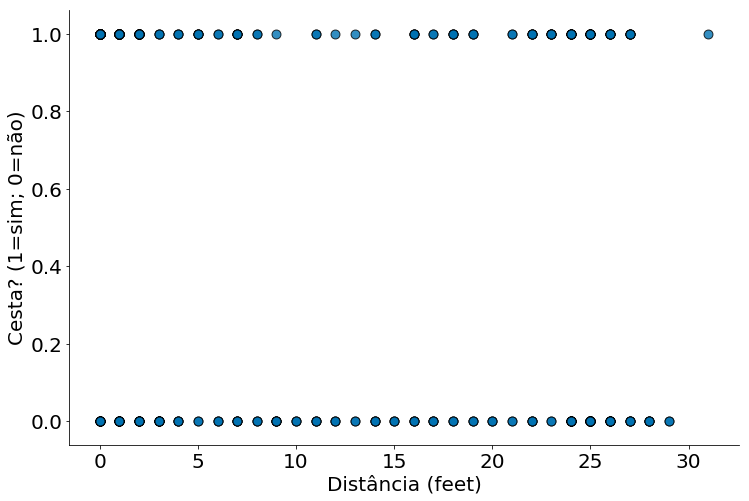

In [70]:
n = df.shape[0]
plt.scatter(df['shot_distance'],
            df['shot_made'],
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

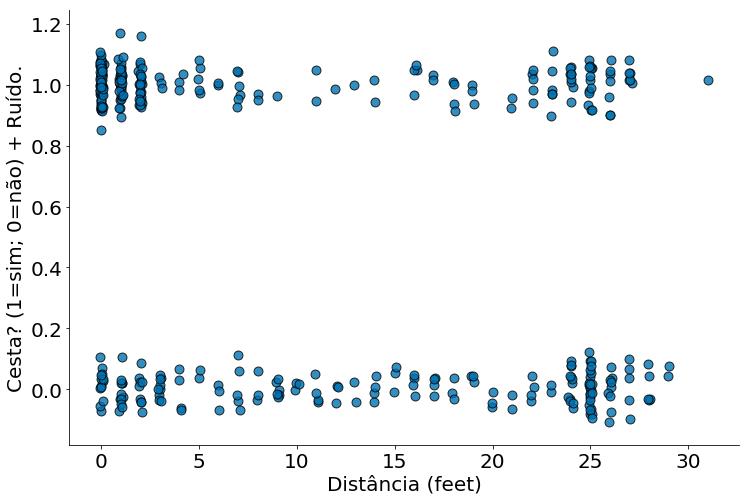

In [71]:
n = df.shape[0]
plt.scatter(df['shot_distance'] + np.random.normal(0, 0.05, size=n),
            df['shot_made'] + np.random.normal(0, 0.05, size=n),
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não) + Ruído.')
despine()

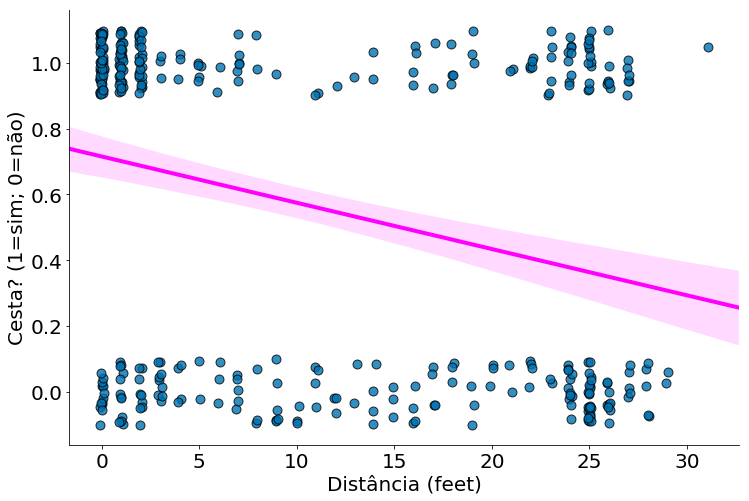

In [72]:
sns.regplot(x='shot_distance', y='shot_made', data=df, n_boot=10000,
            x_jitter=.1, y_jitter=.1,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

In [73]:
def sigmoid(X, theta=1):
    return 1.0 / (1.0 + np.exp(-X.dot(theta)))

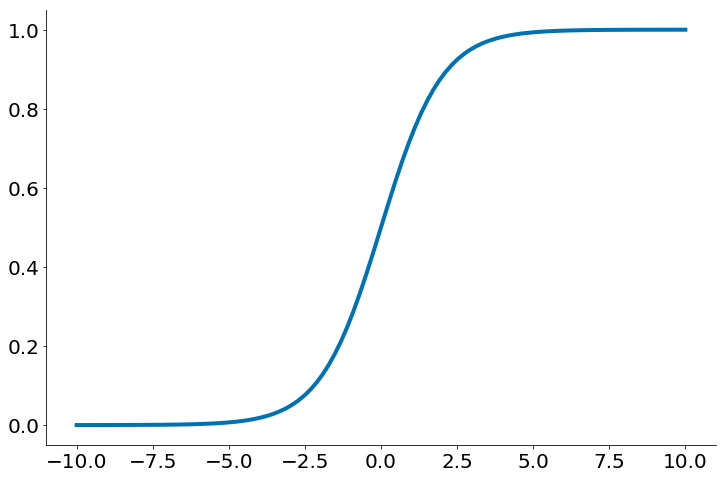

In [74]:
x = np.linspace(-10, 10, 100)
y = sigmoid(x)
plt.plot(x, y)
despine()

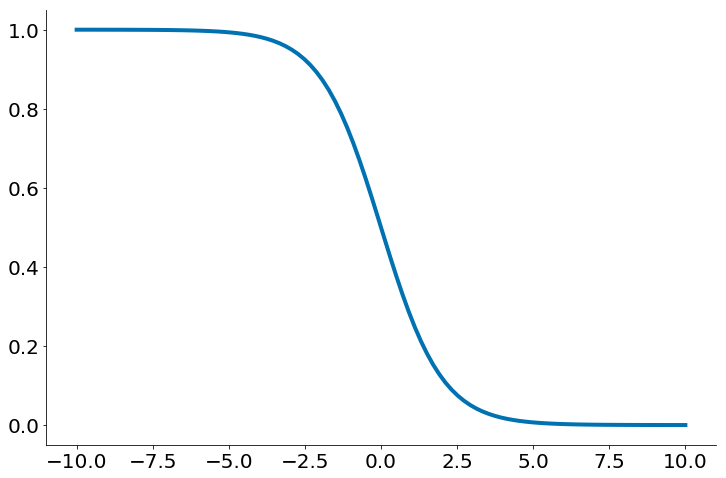

In [11]:
x = np.linspace(-10, 10, 100)
y = sigmoid(x, theta=-1)
plt.plot(x, y)
despine()

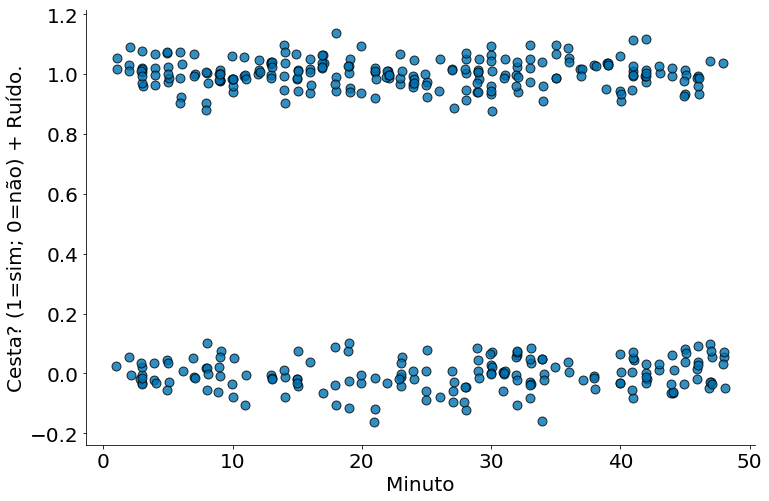

In [13]:
n = df.shape[0]
plt.scatter(df['minute'] + np.random.normal(0, 0.05, size=n),
            df['shot_made'] + np.random.normal(0, 0.05, size=n),
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Minuto')
plt.ylabel('Cesta? (1=sim; 0=não) + Ruído.')
despine()

In [83]:
from sklearn.linear_model import SGDClassifier
X = df[['shot_distance']].copy()
y = df['shot_made']
model = SGDClassifier(loss='log', penalty='none')
model.fit(X, y) ### Execute gradiente descendente!!!
theta = model.coef_

/Users/flaviov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31]


ValueError: x and y must have same first dimension, but have shapes (31,) and (1, 31)

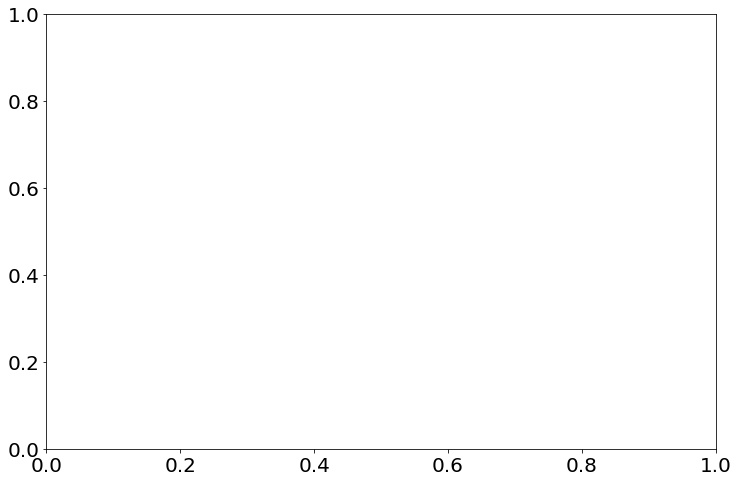

In [100]:
x = np.unique(df['shot_distance'].values)
print(x)
y_previsto = 1.0 / (1 + np.exp(-x * theta))

plt.plot(x, y_previsto)
#plt.scatter(df['shot_distance'], y)

In [93]:
np.unique(df['shot_distance'].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31])

In [101]:
X = df[['shot_distance']].copy()
#X['intercept'] = 1
#y = df['shot_made']
X

,shot_distance
0,0
1,0
2,0
3,0
4,0
5,0
6,7
7,23
8,25
9,11


In [102]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = SGDClassifier(loss='log', penalty='none')
model = model.fit(X_train, y_train)

/Users/flaviov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [109]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

0.69021739130434778

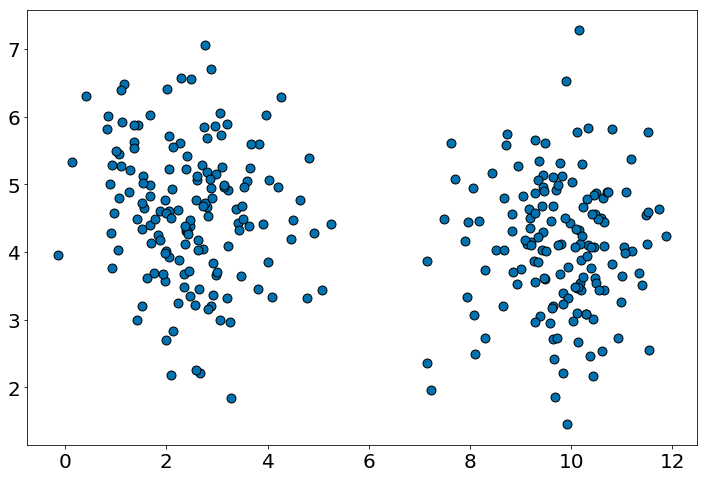

In [110]:
X, y = datasets.make_blobs(n_samples=300, centers=2, n_features=2)
plt.scatter(X[:, 0], X[:, 1], edgecolors='k', s=80)

In [111]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = SGDClassifier(loss='log', penalty='none')
model = model.fit(X_train, y_train)

/Users/flaviov/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [112]:
(model.predict(X_test) == y_test).mean()

0.93999999999999995